# **Outline**

- Downloading and importing a real-world dataset
- Preparing a dataset for training
- Training and interpreting decision trees
- Training and interpreting random forests
- Overfitting, hyperparameter tuning & regularization
- Making predictions on single inputs

# **Problem Statement**

> **QUESTION**: The [Rain in Australia dataset](https://kaggle.com/jsphyg/weather-dataset-rattle-package) contains about 10 years of daily weather observations from numerous Australian weather stations. Here's a small sample from the dataset:
>
> As a data scientist at the Bureau of Meteorology, you are tasked with creating a fully-automated system that can use today's weather data for a given location to predict whether it will rain at the location tomorrow. 


# **Importing Dependencies**

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

# **Accessing Dataset**

In [5]:
df = pd.read_csv('dataset/weatherAUS.csv')
df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


Each row shows the measurements for a given date at a given location. The last column "RainTomorrow" contains the value to be predicted.

Let's check the column types of the dataset.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Let's drop any rows where the value of the target column `RainTomorrow` in empty.

In [7]:
df.dropna(subset=['RainTomorrow'], inplace=True)
df.head(2)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


# **Preparing the Data for Training**

We'll perform the following steps to prepare the dataset for training:

1. Create a train/test/validation split
2. Identify input and target columns
3. Identify numeric and categorical columns
4. Impute (fill) missing numeric values
5. Scale numeric values to the $(0, 1)$ range
6. Encode categorical columns to one-hot vectors

## **Training, Validation and Test Sets**

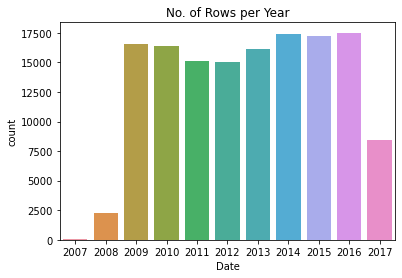

In [8]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(df.Date).dt.year);

While working with chronological data, it's often a good idea to separate the training, validation and test sets with time, so that the model is trained on data from the past and evaluated on data from the future.

We'll use the data till 2014 for the training set, data from 2015 for the validation set, and the data from 2016 & 2017 for the test set.  

In [9]:
year = pd.to_datetime(df.Date).dt.year

train_df = df[year < 2015]
val_df = df[year == 2015]
test_df = df[year > 2015]

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (98988, 23)
val_df.shape : (17231, 23)
test_df.shape : (25974, 23)


## **Input and Target Columns**

Let's identify the input and target columns.

In [10]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Let's also identify the numeric and categorical columns.

In [11]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

print(numeric_cols)
print(categorical_cols)

['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']


## **Imputing missing numeric values**

In [12]:
from sklearn.impute import SimpleImputer

In [13]:
train_inputs[numeric_cols].isna().sum()

MinTemp            434
MaxTemp            198
Rainfall          1000
Evaporation      37110
Sunshine         40696
WindGustSpeed     6902
WindSpeed9am      1133
WindSpeed3pm      1140
Humidity9am       1265
Humidity3pm       1186
Pressure9am       9345
Pressure3pm       9309
Cloud9am         35764
Cloud3pm         36766
Temp9am            783
Temp3pm            663
dtype: int64

In [14]:
imputer = SimpleImputer(strategy = 'mean').fit(df[numeric_cols])

train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

train_inputs[numeric_cols].isna().sum()

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
dtype: int64

## **Scaling Numeric Features**

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
scaler = MinMaxScaler().fit(df[numeric_cols])

train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

val_inputs.describe().loc[['min', 'max']]

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
min,0.007075,0.030246,0.000000,0.000000,0.0,0.007752,0.000000,0.000000,0.04,0.0,0.125620,0.0816,0.000000,0.000000,0.021097,0.026871
max,0.952830,0.948960,0.666307,0.485517,1.0,1.000000,0.669231,0.850575,1.00,1.0,0.971901,0.9632,0.888889,0.888889,0.943038,0.925144


## **Encoding Categorical Data**

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [18]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(df[categorical_cols])

encoded_cols = list(encoder.get_feature_names(categorical_cols))

train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

test_inputs

c:\Users\Dheeraj\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
c:\Users\Dheeraj\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
c:\Users\Dheeraj\anaconda3\lib\site-packages\pandas\core\frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joinin

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
2498,Albury,0.681604,0.801512,0.000000,0.037723,0.525852,ENE,0.372093,NaN,ESE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2499,Albury,0.693396,0.725898,0.001078,0.037723,0.525852,SSE,0.341085,SSE,SE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2500,Albury,0.634434,0.527410,0.005930,0.037723,0.525852,ENE,0.325581,ESE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2501,Albury,0.608491,0.538752,0.042049,0.037723,0.525852,SSE,0.255814,SE,SSE,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2502,Albury,0.566038,0.523629,0.018329,0.037723,0.525852,ENE,0.193798,SE,SSE,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,Uluru,0.283019,0.502836,0.000000,0.037723,0.525852,E,0.193798,ESE,E,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145455,Uluru,0.266509,0.533081,0.000000,0.037723,0.525852,E,0.193798,SE,ENE,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145456,Uluru,0.285377,0.568998,0.000000,0.037723,0.525852,NNW,0.124031,SE,N,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145457,Uluru,0.327830,0.599244,0.000000,0.037723,0.525852,N,0.240310,SE,WNW,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.

In [19]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

X_test

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,WindDir3pm_nan,RainToday_No,RainToday_Yes,RainToday_nan
2498,0.681604,0.801512,0.000000,0.037723,0.525852,0.372093,0.000000,0.080460,0.46,0.17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2499,0.693396,0.725898,0.001078,0.037723,0.525852,0.341085,0.069231,0.195402,0.54,0.30,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2500,0.634434,0.527410,0.005930,0.037723,0.525852,0.325581,0.084615,0.448276,0.62,0.67,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2501,0.608491,0.538752,0.042049,0.037723,0.525852,0.255814,0.069231,0.195402,0.74,0.65,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2502,0.566038,0.523629,0.018329,0.037723,0.525852,0.193798,0.046154,0.103448,0.92,0.63,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,0.283019,0.502836,0.000000,0.037723,0.525852,0.193798,0.115385,0.149425,0.59,0.27,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145455,0.266509,0.533081,0.000000,0.037723,0.525852,0.193798,0.100000,0.126437,0.51,0.24,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145456,0.285377,0.568998,0.000000,0.037723,0.525852,0.124031,0.100000,0.103448,0.56,0.21,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
145457,0.327830,0.599244,0.000000,0.037723,0.525852,0.240310,0.069231,0.103448,0.53,0.24,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# **Training and Visualizing Decision Trees**

A decision tree in general parlance represents a hierarchical series of binary decisions:

<img src="https://i.imgur.com/qSH4lqz.png" width="480">

A decision tree in machine learning works in exactly the same way, and except that we let the computer figure out the optimal structure & hierarchy of decisions, instead of coming up with criteria manually.

## **Training**

We can use `DecisionTreeClassifier` from `sklearn.tree` to train a decision tree.

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
model = DecisionTreeClassifier(random_state=42)

In [22]:
model.fit(X_train, train_targets)

DecisionTreeClassifier(random_state=42)

An optimal decision tree has now been created using the training data.

## **Evaluation**

Let's evaluate the decision tree using the accuracy score.

In [31]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [26]:
train_preds = model.predict(X_train)
train_preds

array(['No', 'No', 'No', ..., 'No', 'No', 'No'], dtype=object)

In [27]:
pd.value_counts(train_preds)

No     76707
Yes    22281
dtype: int64

The decision tree also returns probabilities for each prediction.

In [29]:
train_probs = model.predict_proba(X_train)
train_probs

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

Seems like the decision tree is quite confident about its predictions.

Let's check the accuracy of its predictions.

In [32]:
accuracy_score(train_targets, train_preds)

0.9999797955307714

The training set accuracy is close to 100%! But we can't rely solely on the training set accuracy, we must evaluate the model on the validation set too. 

We can make predictions and compute accuracy in one step using `model.score`

In [33]:
model.score(X_val, val_targets)

0.7921188555510418

Although the training accuracy is 100%, the accuracy on the validation set is just about 79%, which is only marginally better then always predicting "No". 

In [34]:
val_targets.value_counts() / len(val_targets)

No     0.788289
Yes    0.211711
Name: RainTomorrow, dtype: float64

It appears that the model has learned the training examples perfect, and doesn't generalize well to previously unseen examples. This phenomenon is called **overfitting**, and reducing overfitting is one of the most important parts of any machine learning project.

## **Visualization**

We can visualize the decision tree _learned_ from the training data.

In [35]:
from sklearn.tree import plot_tree, export_text

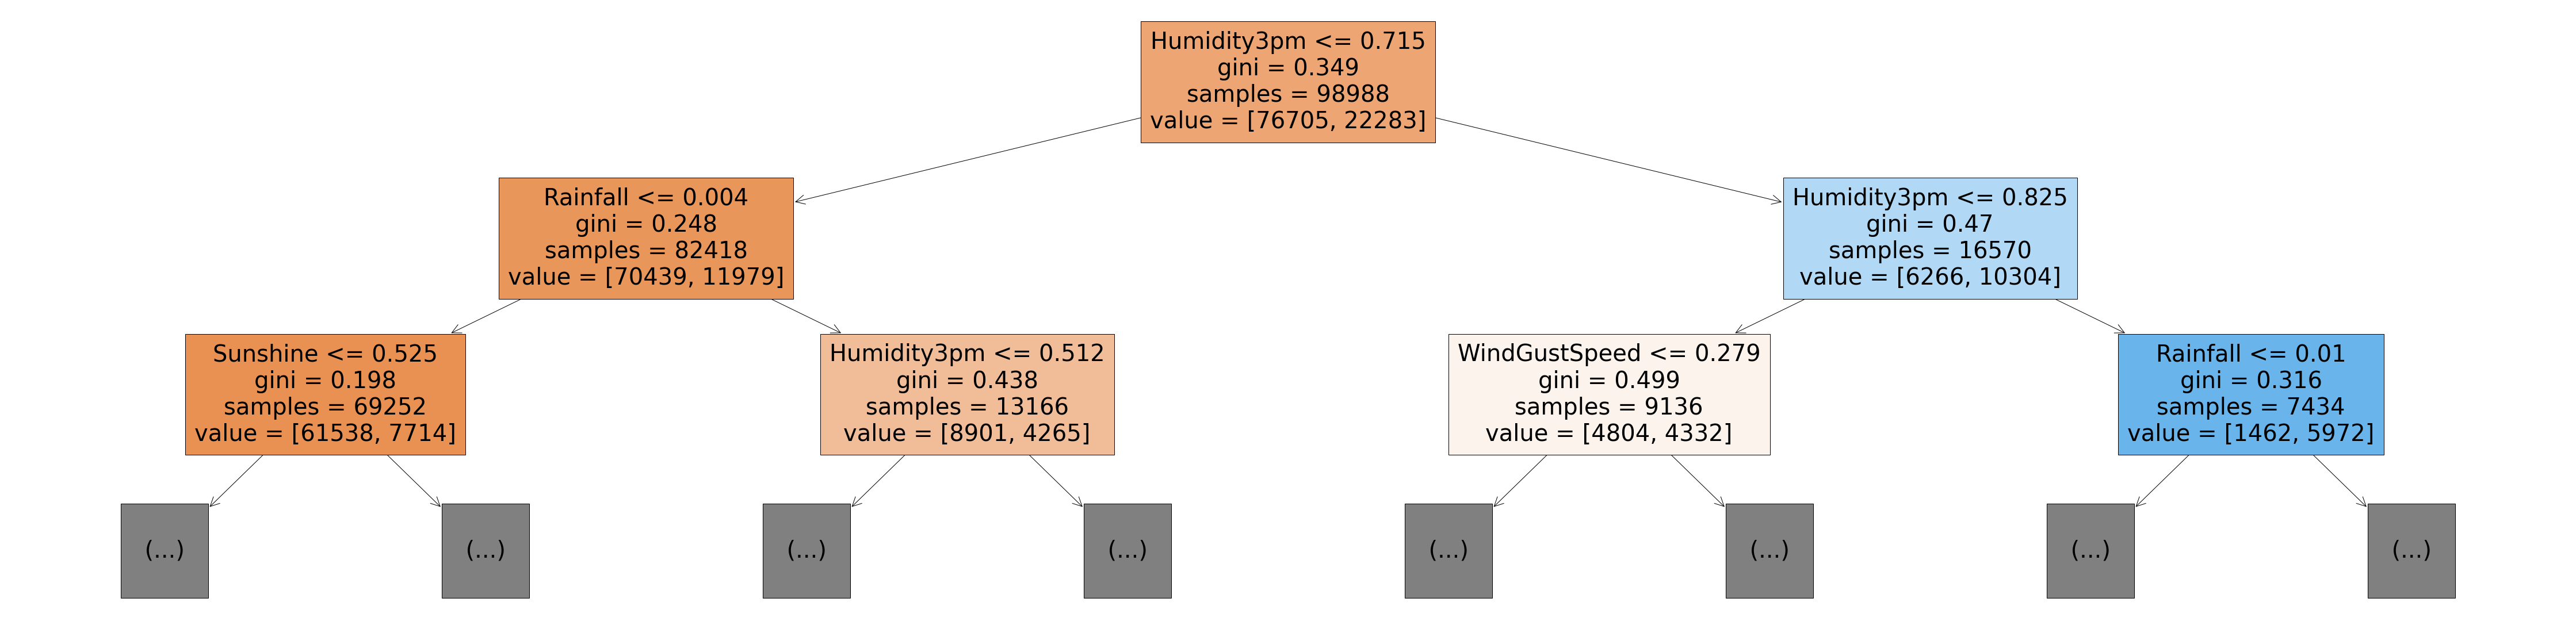

In [36]:
plt.figure(figsize=(80,20))
plot_tree(model, feature_names=X_train.columns, max_depth=2, filled=True);

The tree is truncated here, but following any path from the root node down to a leaf will result in "Yes" or "No".

**How a Decision Tree is Created**

Note the `gini` value in each box. This is the loss function used by the decision tree to decide which column should be used for splitting the data, and at what point the column should be split. A lower Gini index indicates a better split. A perfect split (only one class on each side) has a Gini index of 0. 

It has the following formula:

<img src="https://i.imgur.com/CSC0gAo.png" width="240">

Conceptually speaking, while training the models evaluates all possible splits across all possible columns and picks the best one. Then, it recursively performs an optimal split for the two portions. In practice, however, it's very inefficient to check all possible splits, so the model uses a heuristic (predefined strategy) combined with some randomization.

The iterative approach of the machine learning workflow in the case of a decision tree involves growing the tree layer-by-layer:

<img src="https://www.deepnetts.com/blog/wp-content/uploads/2019/02/SupervisedLearning.png" width="480">


Let's check the depth of the tree that was created.

In [37]:
model.tree_.max_depth

48

We can also display the tree as text, which can be easier to follow for deeper trees.

In [38]:
tree_text = export_text(model, max_depth=10, feature_names=list(X_train.columns))
print(tree_text[:5000])

|--- Humidity3pm <= 0.72
|   |--- Rainfall <= 0.00
|   |   |--- Sunshine <= 0.52
|   |   |   |--- Pressure3pm <= 0.58
|   |   |   |   |--- WindGustSpeed <= 0.36
|   |   |   |   |   |--- Humidity3pm <= 0.28
|   |   |   |   |   |   |--- WindDir9am_NE <= 0.50
|   |   |   |   |   |   |   |--- Location_Watsonia <= 0.50
|   |   |   |   |   |   |   |   |--- Cloud9am <= 0.83
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm <= 0.07
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm <= 0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: Yes
|   |   |   |   |   |   |   |   |   |   |--- Pressure3pm >  0.46
|   |   |   |   |   |   |   |   |   |   |   |--- class: No
|   |   |   |   |   |   |   |   |   |--- WindSpeed3pm >  0.07
|   |   |   |   |   |   |   |   |   |   |--- MinTemp <= 0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- MinTemp >  0.32
|   |   |   |   |   |   |   |   |   |   |   |--- truncated